In [1]:
from dotenv import load_dotenv
import os
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from sklearn.decomposition import PCA
import numpy as np
from datasets import load_dataset

## env setup

In [2]:
env_path = r"D:\common_credentials\.env"
load_dotenv(dotenv_path=env_path)

True

## Embeddings

In [3]:
embedding_model= GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

In [4]:
texts = [
    "The cat sat on the mat.",
    "The feline rested on the rug.",
    "A black dog barked loudly.",
    "A dark canine howled fiercely.",
    "The car is red.",
    "The vehicle is a crimson color.",
    "I went to the store.",
    "I visited the market.",
    "The cat sat on the mat.",  # Repeated to show clustering
    "The sun is shining brightly.",
    "I like to eat pizza.",
    "Elephants live in Africa.",
    "Rakesh spending his free time near the river bank"
]
text_embeddings= [embedding_model.embed_query(line) for line in texts]
pca= PCA(2)
twodimsData= pca.fit_transform(np.array(text_embeddings))
twodimsData.shape

(13, 2)

        PC1       PC2                        Sentence
0  0.540475  0.224512         The cat sat on the mat.
1  0.436995  0.122190   The feline rested on the rug.
2  0.121576 -0.234697      A black dog barked loudly.
3  0.143392 -0.297338  A dark canine howled fiercely.
4 -0.113654 -0.470702                 The car is red.


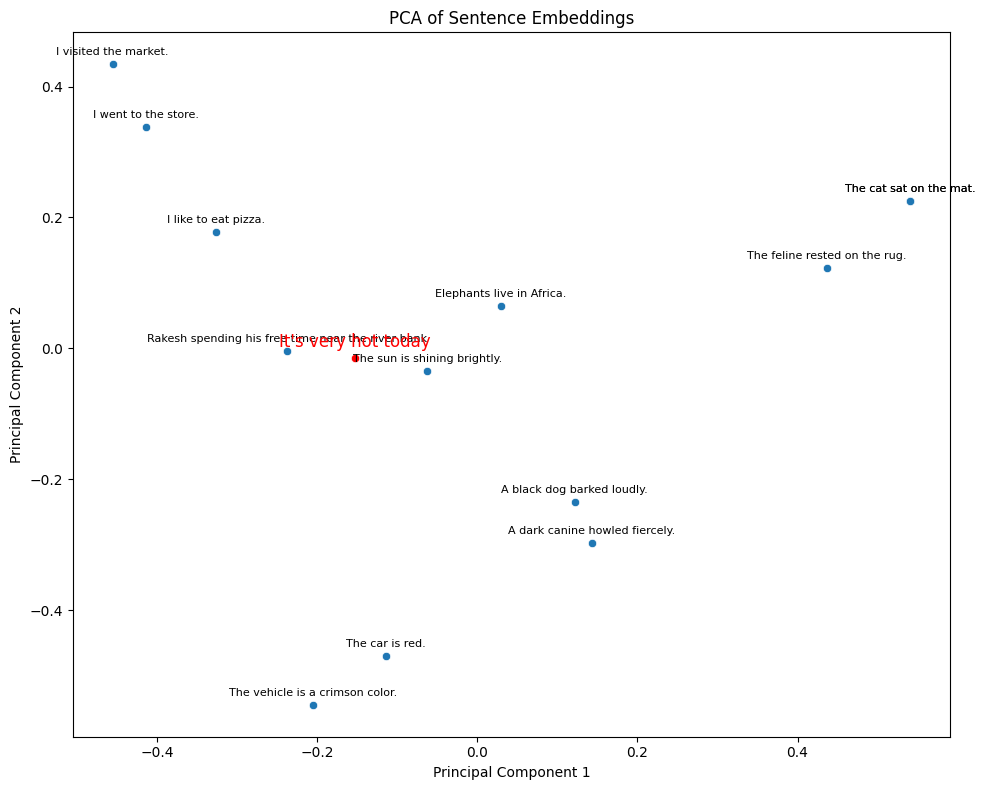

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.DataFrame({'PC1': twodimsData[:, 0], 'PC2': twodimsData[:, 1], 'Sentence': texts})
print(df.head())

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', data=df)
for i, sentence in enumerate(texts):
    plt.annotate(sentence, (df['PC1'][i], df['PC2'][i]), fontsize=8, ha='center', va='bottom', xytext=(0,5), textcoords='offset points')

## another sentence
text2= "It's very hot today"
embed2= embedding_model.embed_query(text2)
embed2= np.array(embed2)
pca2= pca.transform(embed2.reshape(1,-1))
x1, x2=  pca2[:, 0], pca2[:, 1]
sns.scatterplot(x=x1, y=x2, color="r", markers="*")
plt.annotate(text2, (x1, x2), fontsize=12, color='red', ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')
plt.title('PCA of Sentence Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

## Data Preparation

In [8]:
data= load_dataset("csv", data_files="./medical-o1-verifiable-problem_1000records.csv")
data

DatasetDict({
    train: Dataset({
        features: ['Open-ended Verifiable Question', 'Ground-True Answer'],
        num_rows: 1000
    })
})

In [13]:
data_list= data['train']['Open-ended Verifiable Question']
type(data_list), len(data_list)

(list, 1000)

## Pinecone Vector DB

In [21]:
embedding_model= GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

In [18]:
#embdding diamesions
embedding_dims= len(embedding_model.embed_query("hello"))
embedding_dims

768

In [22]:
from pinecone import Pinecone, ServerlessSpec
pinecone_client= Pinecone(api_key=os.getenv("PINECONE_API_KEY"))

In [29]:
# dir(pinecone_client)
pinecone_client.list_indexes()

[]

In [48]:
# index_name = "quickstart"

# pinecone_client.create_index(
#     name=index_name,
#     dimension=2, # Replace with your model dimensions
#     metric="cosine", # Replace with your model metric
#     spec=ServerlessSpec(
#         cloud="aws",
#         region="us-east-1"
#     ) 
# )

In [45]:
#create the index
my_index_name= "medicaldata" #index name should not have special characters
existing_indexes = [index_info["name"] for index_info in pinecone_client.list_indexes()]

import time 

if my_index_name not in existing_indexes: #checking the presence of indexnames
    #create index
    pinecone_client.create_index(
        name=my_index_name,
        dimension=embedding_dims, #768
        metric="cosine", ## Can be "euclidean", "cosine", or "dotproduct"
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
        deletion_protection="enabled" #can not delete the data
    )
    # index_type="hnsw",  # Use hnsw, ivf, flat, etc.

    while not pinecone_client.describe_index(my_index_name).status["ready"]:
        time.sleep(1)


In [47]:
#check the index status
pinecone_client.describe_index(my_index_name)

{
    "name": "medicaldata",
    "dimension": 768,
    "metric": "cosine",
    "host": "medicaldata-uh51rcu.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "deletion_protection": "enabled"
}

In [51]:
pinecone_index= pinecone_client.Index(my_index_name)
pinecone_index

In [52]:
#create the vectorstore
from langchain_pinecone import PineconeVectorStore
vector_store= PineconeVectorStore(index=pinecone_index,
                                  embedding= embedding_model,
                                  distance_strategy="cosine")

In [67]:
from uuid import uuid4
uuids= [str(uuid4()) for _ in range(len(data_list))]
uuids[:2]

['2e2bd303-a197-4aa6-9e59-1258baf8639b',
 '66919a6d-2f52-40e9-b5d8-94570bce9872']

In [73]:
from langchain_core.documents import Document
documents= [Document(page_content=text) for text in data_list]
documents[:2]

[Document(metadata={}, page_content='An 88-year-old woman with osteoarthritis is experiencing mild epigastric discomfort and has vomited material resembling coffee grounds multiple times. Considering her use of naproxen, what is the most likely cause of her gastrointestinal blood loss?'),
 Document(metadata={}, page_content='In the context of disseminated intravascular coagulation (DIC), which blood component is expected to show an increase due to the excessive breakdown of fibrin?')]

In [74]:
## Adding documents to the vector stores
vector_store.add_documents(documents=documents, ids=uuids )

['2e2bd303-a197-4aa6-9e59-1258baf8639b',
 '66919a6d-2f52-40e9-b5d8-94570bce9872',
 '74455feb-5acb-4c84-ae43-037e821322a7',
 '3f8559ea-d43a-47be-9a95-a64b07bc367f',
 '53f8646f-41e7-43a9-9327-641be8bc3f49',
 '77bf15ec-9b37-4531-a48b-12d3e88c8f91',
 '3bf9f509-8f9e-4ef3-aef2-c92bbea7641c',
 '48eead58-c894-4da1-ba9f-f9f42f5948cb',
 '93c06a26-f624-4c2a-97f9-d47fd9ab9912',
 'fd0f3650-3297-45bb-a270-3052bbcc985a',
 '04897ff8-2416-453c-98b1-7d14090d057b',
 'ad15a290-d04b-4875-87d6-6e1ad9127fd5',
 'ad777fdf-821d-4d15-8e1c-eccb6c689a12',
 '1dc18eba-cdb4-4022-b324-26c2ac3e71e4',
 '36477f5c-70e0-47e5-bae7-4f0ca392a998',
 'b165f6ec-57e8-44ed-a057-476e3dbd387a',
 'ff849e8c-508f-4ac4-9369-b946eac31a08',
 '81c1cc66-3e14-4e13-9526-27874b4c2362',
 '4621eb74-7409-4cb7-ae97-2be39c1c2b05',
 'e83e2ee5-0ef1-4cfe-8564-d62d6ae1de07',
 'a8e40efa-f3a9-47b3-b46e-e3df88bb1119',
 '7d3bf343-9e60-4971-940f-0b5fc2cb4ca4',
 '6c95503d-7862-4637-905c-e66a3d203139',
 'f04949c8-cd21-4b8d-bf77-7f6bed792f2c',
 '4b952768-470c-

In [75]:
## get the relevant information from pinecone data

## Querying the vector store

In [82]:
data['train']['Open-ended Verifiable Question'][778]

'What is the most likely diagnosis for a 26-year-old pregnant woman in her first trimester who presents with retching, repeated vomiting with large hematemesis, a pulse rate of 126/min, and a systolic blood pressure of 80 mm Hg?'

In [ ]:
results = vector_store.similarity_search(
    "LangChain provides abstractions to make working with LLMs easy",
    k=2,
    filter={"source": "tweet"},
)


In [81]:
help(vector_store.similarity_search)

Help on method similarity_search in module langchain_pinecone.vectorstores:

similarity_search(query: 'str', k: 'int' = 4, filter: 'Optional[dict]' = None, namespace: 'Optional[str]' = None, **kwargs: 'Any') -> 'List[Document]' method of langchain_pinecone.vectorstores.PineconeVectorStore instance
    Return pinecone documents most similar to query.
    
    Args:
        query: Text to look up documents similar to.
        k: Number of Documents to return. Defaults to 4.
        filter: Dictionary of argument(s) to filter on metadata
        namespace: Namespace to search in. Default will search in '' namespace.
    
    Returns:
        List of Documents most similar to the query and score for each



In [83]:
vector_store.similarity_search(
    query="What is the most probable diagnosis for a 26-year-old pregnant woman in her first trimester who presents with persistent retching, frequent vomiting accompanied by significant hematemesis",
    k=4
)

[Document(id='ebb65c69-9fdd-4be2-8be4-d7f2bacafe1e', metadata={}, page_content='What is the most likely diagnosis for a 26-year-old pregnant woman in her first trimester who presents with retching, repeated vomiting with large hematemesis, a pulse rate of 126/min, and a systolic blood pressure of 80 mm Hg?'),
 Document(id='eb5bb735-a028-478a-b990-05ccac5a43a2', metadata={}, page_content='In a 40-year-old patient with a history of chronic alcoholism presenting with distended abdomen, hematemesis, fresh blood in stool, huge ascites, and distended veins over the abdominal wall, what is the most likely cause of hematemesis?'),
 Document(id='29272515-be48-4af1-8fd9-9a7504c0bde8', metadata={}, page_content='A child presents with massive hematemesis, systemic hypotension, and has massive splenomegaly without hepatomegaly. With no fever or other significant history reported, what is the likely diagnosis?'),
 Document(id='9c700258-6599-480a-aabb-0c73c3483046', metadata={}, page_content='A 23-ye

In [89]:
responses = vector_store.similarity_search(
    query="What is the most probable diagnosis for a 26-year-old pregnant woman in her first trimester who presents with persistent retching, frequent vomiting accompanied by significant hematemesis",
    k=4
)

for idx, resp in enumerate (responses):
    print(idx, "-->", resp.page_content)

0 --> What is the most likely diagnosis for a 26-year-old pregnant woman in her first trimester who presents with retching, repeated vomiting with large hematemesis, a pulse rate of 126/min, and a systolic blood pressure of 80 mm Hg?
1 --> In a 40-year-old patient with a history of chronic alcoholism presenting with distended abdomen, hematemesis, fresh blood in stool, huge ascites, and distended veins over the abdominal wall, what is the most likely cause of hematemesis?
2 --> A child presents with massive hematemesis, systemic hypotension, and has massive splenomegaly without hepatomegaly. With no fever or other significant history reported, what is the likely diagnosis?
3 --> A 23-year-old woman with a history of an unspecified coagulation disorder was admitted to a psychiatric emergency room exhibiting symptoms such as rapid speech, inappropriate behavior, and lack of sleep. Her symptoms improved after 4 days of treatment. Five months later, she is found to be 3 months pregnant. Ba

In [97]:
##creating retreiver obj
retriever= vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 4}
                    )

#invoking
responses= retriever.invoke(input="What is the most probable diagnosis for a 26-year-old pregnant woman in her first trimester who presents with persistent retching, frequent vomiting accompanied by significant hematemesis")

In [99]:
for idx, resp in enumerate (responses):
    print(idx, "-->", resp.page_content)

0 --> What is the most likely diagnosis for a 26-year-old pregnant woman in her first trimester who presents with retching, repeated vomiting with large hematemesis, a pulse rate of 126/min, and a systolic blood pressure of 80 mm Hg?
1 --> In a 40-year-old patient with a history of chronic alcoholism presenting with distended abdomen, hematemesis, fresh blood in stool, huge ascites, and distended veins over the abdominal wall, what is the most likely cause of hematemesis?
2 --> A child presents with massive hematemesis, systemic hypotension, and has massive splenomegaly without hepatomegaly. With no fever or other significant history reported, what is the likely diagnosis?
3 --> A 23-year-old woman with a history of an unspecified coagulation disorder was admitted to a psychiatric emergency room exhibiting symptoms such as rapid speech, inappropriate behavior, and lack of sleep. Her symptoms improved after 4 days of treatment. Five months later, she is found to be 3 months pregnant. Ba

# Advantages:

- Allows to select the indexing algorithms 
    - HNSW (Hierarchical Navigable Small World)
    - IVF (Inverted File Index)
    - PQ (Product Quantization)
    - Flat (Brute-Force Search)
    - Annoy (Approximate Nearest Neighbors Oh Yeah)
    - Spherical k-means

- Provide visuals of database (where we can see the vectors along with metadata), easy to debug & understand
- Provide serverless database
- Well known among the community
- Scalable
- Secured
- Easy to integrate with HuggingFace, LangChain & Llama Index, etc.
